In [47]:
from z3 import *
import numpy as np
import copy
import time
from matplotlib import pyplot as plt

In [5]:
def utility_delta(util):
    util_delta = []
    for row in util:
        delta_row = [round(row[i] - row[i-1], 4) if i > 0 else row[i] for i in range(len(row))]
        util_delta.append(delta_row)

#     print("util_delta")
#     print(util_delta)
    return util_delta

In [6]:
def solver(util, pre_decision, B):

    # Number of objects
    num_objects = len(util)

    # Number of layers per object
    num_layers = len(util[0])

    print("Solver:")
#     print("Previous decision")
#     for i in range(num_objects):
#         print("Object", i, pre_decision[i])
#     print()

    start = time.time()
    solver = Optimize()

    # Decision variables: 2D array of boolean variables
    # decision[i][j] represents whether to select layer j of object i
    decision = [[Bool(f"decision_{i}_{j}") for j in range(num_layers)] for i in range(num_objects)]

    # Constraint 1: Bandwidth
    solver.add(Sum([If(decision[i][j], 1, 0) for i in range(num_objects) for j in range(num_layers)]) <= B)

    # Constraint 2: Selection should exclude elements already chosen in previous decision
    for i in range(num_objects):
        for j in range(num_layers):
            if pre_decision[i][j] > 0:
                # If a layer was selected in the previous decision, it cannot be selected again
                solver.add(decision[i][j] == False)

    # Constraint 3: Lower layers should be selected before upper layer
    for i in range(num_objects):
        for j in range(1, num_layers):
            if pre_decision[i][0] == 1:
                lower_layer_selected = True 
    #             lower_layer_selected = Or(decision[i][0], True)
            else:
                lower_layer_selected = decision[i][0]
    #             lower_layer_selected = Or(decision[i][0], False)
            for k in range(j):
                if pre_decision[i][k] == 1:
                    lower_layer_selected = And(lower_layer_selected, True)
    #                 lower_layer_selected = And(lower_layer_selected, Or(decision[i][k], True))
                else:
                    lower_layer_selected = And(lower_layer_selected, decision[i][k])
    #                 lower_layer_selected = And(lower_layer_selected, Or(decision[i][k], False))

            solver.add(Implies(decision[i][j], lower_layer_selected))


    # Objective: Maximize the sum of utility
    objective = Sum([util[i][j] * If(decision[i][j], 1, 0) for i in range(num_objects) for j in range(num_layers)])
    solver.maximize(objective)


    if solver.check() == sat:
        model = solver.model()
        max_utility = model.evaluate(objective).as_decimal(5)
        selected_layers = [[model[decision[i][j]] for j in range(num_layers)] for i in range(num_objects)]
        print("Time elapsed:", round((time.time() - start)*1000, 2), "ms")
        print("Max utility:",max_utility)
        print("Decision variables (selected layers):")
        decision = copy.deepcopy(pre_decision)
        for i in range(num_objects):
            print(f"Object {i}: {[j for j in range(num_layers) if selected_layers[i][j]]}")
            for j in range(num_layers):
                if selected_layers[i][j]:
                    decision[i][j] = 1

        print()

        print("Updated decision after optimization")
        for i in range(num_objects):
            print("Object", i, decision[i])
#             print(decision[i], ',')


    else:
        print("No solution found.")

In [7]:
def maximize_utility_prefer_all(util, pre_decision, B):
    num_objects = len(util)
    num_layers = len(util[0])
    
    print("Iterative but prefer all layers of an object:")
#     print("Previous decision")
#     for i in range(num_objects):
#         print("Object", i, pre_decision[i])
#     print()
    
    start = time.time()
    budget = B
    
    def getOne(budget, pre_decision):
        selected_layers = [[0] * num_layers for _ in range(num_objects)]
        while budget > 0:
            # Extract the last next potential layer for each object based on previous decision
            # If all layers are retrieved, return -1
            next_layer = list(map(lambda row: next((index for index, value in enumerate(row) if value == 0), -1), pre_decision))
    #         print(next_layer)
            # Terminate when nothing to select
            if next_layer == [-1] * num_objects:
                break
            # Get 1 at a time
            max_utility = float('-inf')
            selected_obj = None
            for obj_idx, layer_idx in enumerate(next_layer):
                if layer_idx != -1 and util[obj_idx][layer_idx] > max_utility:
                    max_utility = util[obj_idx][layer_idx]
                    selected_obj = obj_idx

            # Select the object and layer with max utility and update budget
            if selected_obj is not None:
                selected_layers[selected_obj][next_layer[selected_obj]] = 1
                budget -= 1
                # Update the pre_decision
                pre_decision[selected_obj][next_layer[selected_obj]] = 1

                
            
        # Calculate the total utility
        total_utility = sum(util[obj_idx][layer_idx] for obj_idx in range(num_objects) for layer_idx in range(num_layers) if selected_layers[obj_idx][layer_idx] == 1)
        return budget, total_utility, selected_layers
    
    def getAll(budget, pre_decision):
        selected_layers = [[0] * num_layers for _ in range(num_objects)]
        while budget > 0:
            # Extract the last next potential layer for each object based on previous decision
            # If all layers are retrieved, return -1
            next_layer = list(map(lambda row: next((index for index, value in enumerate(row) if value == 0), -1), pre_decision))
    #         print(next_layer)
            # Terminate when nothing to select
            if next_layer == [-1] * num_objects:
                break
            # Try to see if we can get all layers from an object  
            max_utility = float('-inf')
            selected_obj = None
            for obj_idx, layer_idx in enumerate(next_layer):
                if layer_idx != -1 and num_layers - layer_idx <= budget:
                    util_sum = 0
                    for l in range(layer_idx, num_layers):
                        util_sum += util[obj_idx][l]
#                     print(util_sum, obj_idx)
                    if util_sum > max_utility:
                        max_utility = util_sum
                        selected_obj = obj_idx
            
            if selected_obj is not None:
                layer_idx = next_layer[selected_obj]
                selected_layers[selected_obj][layer_idx:num_layers] = [1]*(num_layers-layer_idx)
                # Update the pre_decision
                pre_decision[selected_obj][layer_idx:num_layers] = [1]*(num_layers-layer_idx)
                budget -= (num_layers-layer_idx)
            else:
                break
#             if (budget > 0):
#                 budget, utility, selected = getOne(budget, pre_decision)
#                 for i in range(num_objects):
#                     for j in range(num_layers):
#                         if selected[i][j]:
#                             selected_layers[i][j] = 1
#                 print(budget)
                
        total_utility = sum(util[obj_idx][layer_idx] for obj_idx in range(num_objects) for layer_idx in range(num_layers) if selected_layers[obj_idx][layer_idx] == 1)
        return budget, pre_decision, total_utility, selected_layers
    
    
    budget, pre_decision_after_all, util1, selected_layers1 = getAll(B, copy.deepcopy(pre_decision))
#     print("getAll before", util1, selected_layers1)
    if budget > 0:
        budget, utility, selected = getOne(budget, pre_decision_after_all)
        for i in range(num_objects):
            for j in range(num_layers):
                if selected[i][j]:
                    selected_layers1[i][j] = 1
                    util1 += util[i][j]
    
#     print("getAll after", util1, selected_layers1)
    budget, util2, selected_layers2 = getOne(B, copy.deepcopy(pre_decision))
#     print("getOne", util2, selected_layers2)
    if util1 > util2:
        total_utility = util1
        selected_layers = selected_layers1
    else:
        total_utility = util2
        selected_layers = selected_layers2
    
    
    print("Time elapsed:", round((time.time() - start)*1000,2), "ms")
    print("Max utility:", round(total_utility,4))
    print("Decision variables (selected layers):")
    for i in range(num_objects):
        print(f"Object {i}: {[j for j in range(num_layers) if selected_layers[i][j]]}")

#     print()
#     updated_decision = np.array(pre_decision)+np.array(selected_layers)
#     print("Updated decision after optimization:")
#     for i in range(num_objects):
#             print("Object", i, updated_decision[i])

    return total_utility, selected_layers

In [8]:
def maximize_utility_one_at_a_time(util, pre_decision, B):
    num_objects = len(util)
    num_layers = len(util[0])
    selected_layers = [[0] * num_layers for _ in range(num_objects)]
    
    print("Iterative select one at a time")
#     print("Previous decision")
#     for i in range(num_objects):
#         print("Object", i, pre_decision[i])
#     print()
    
    start = time.time()
    budget = B
    
    while budget > 0:
        # Extract the last next potential layer for each object based on previous decision
        # If all layers are retrieved, return -1
        next_layer = list(map(lambda row: next((index for index, value in enumerate(row) if value == 0), -1), pre_decision))
#         print(next_layer)
        # Terminate when nothing to select
        if next_layer == [-1] * num_objects:
            break
                    
        # Get 1 at a time
        max_utility = float('-inf')
        selected_obj = None
        for obj_idx, layer_idx in enumerate(next_layer):
            if layer_idx != -1 and util[obj_idx][layer_idx] > max_utility:
                max_utility = util[obj_idx][layer_idx]
                selected_obj = obj_idx
                
        # Select the object and layer with max utility and update budget
        if selected_obj is not None:
            selected_layers[selected_obj][next_layer[selected_obj]] = 1
            budget -= 1
            # Update the pre_decision
            pre_decision[selected_obj][next_layer[selected_obj]] = 1
    
    # Calculate the total utility
    total_utility = sum(util[obj_idx][layer_idx] for obj_idx in range(num_objects) for layer_idx in range(num_layers) if selected_layers[obj_idx][layer_idx] == 1)
    
    
    print("Time elapsed:", round((time.time() - start)*1000,2), "ms")
    print("Max utility:", round(total_utility,4))
    print("Decision variables (selected layers):")
    for i in range(num_objects):
        print(f"Object {i}: {[j for j in range(num_layers) if selected_layers[i][j]]}")

#     print()
#     print("Updated decision after optimization:")
#     for i in range(num_objects):
#             print("Object", i, pre_decision[i])

    return total_utility, selected_layers

In [27]:
def maximize_utility_brute_force(util, pre_decision, B):
    num_objects = len(util)
    num_layers = len(util[0])
    selected_layers = [[0] * num_layers for _ in range(num_objects)]
    
    print("Brute force:")
#     print("Previous decision")
#     for i in range(num_objects):
#         print("Object", i, pre_decision[i])
#     print()
    
    start = time.time()
    selection = 1
    
    # Store all possibilities of selecting 1, 2, .. B items
    memo = {}
    
    while selection <= B:
        # memo[prev] + Get 1 at a time
        if selection == 1:
            next_layer = list(map(lambda row: next((index for index, value in enumerate(row) if value == 0), -1), pre_decision))
            if next_layer == [-1] * num_objects:
                break
            memo[selection] = []
            for obj_idx, layer_idx in enumerate(next_layer):
                if layer_idx != -1:
                    memo[selection].append([obj_idx, layer_idx])
        elif selection == 2:
            memo[selection] = []
            for prev in memo[selection-1]:
                decision = copy.deepcopy(pre_decision)
                decision[prev[0]][prev[1]] = 1

                next_layer = list(map(lambda row: next((index for index, value in enumerate(row) if value == 0), -1), decision))
                if next_layer == [-1] * num_objects:
                    break

                for obj_idx, layer_idx in enumerate(next_layer):
                    if layer_idx != -1:
                        if obj_idx >= prev[0]:
                            temp = memo[selection]
                            temp.append([prev, [obj_idx, layer_idx]])
                            memo[selection] = temp
        else:
            memo[selection] = []
            for prev in memo[selection-1]:
#                 print("prev", prev)
                decision = copy.deepcopy(pre_decision)
                for p in prev:
                    decision[p[0]][p[1]] = 1
                
                next_layer = list(map(lambda row: next((index for index, value in enumerate(row) if value == 0), -1), decision))
                if next_layer == [-1] * num_objects:
                    break
                
                for obj_idx, layer_idx in enumerate(next_layer):
                    if layer_idx != -1:
                        temp =[]
                        for p in prev:
#                             print('p', p)
                            temp.append(p)
                        if obj_idx >= p[0]: # avoid duplicate cases by checking the latest p's object id
                            temp.append([obj_idx, layer_idx])
                            memo[selection].append(temp)
        selection += 1
        
        
    max_utility = float('-inf')
    max_selection =[]
    selected_layers = [[0] * num_layers for _ in range(num_objects)]
    for selection in memo[B]:
        utility = 0
        for (obj_idx, layer_idx) in selection:
            utility += util[obj_idx][layer_idx]
        if utility > max_utility:
            max_utility = utility
            max_selection = selection
#             print(max_utility, max_selection)
    
    print("Time elapsed:", round((time.time() - start)*1000,2), "ms")
    print("Max utility:", round(max_utility,4))
    print("Decision variables (selected layers):")
    for (o,l) in max_selection:
        selected_layers[o][l] = 1
    for i in range(num_objects):
        print(f"Object {i}: {[j for j in range(num_layers) if selected_layers[i][j]]}")

        
#     for i in memo:
#         print(i, memo[i],'\n')
#     print()
#     updated_decision = np.array(pre_decision)+np.array(selected_layers)
#     print("Updated decision after optimization:")
#     for i in range(num_objects):
#             print("Object", i, updated_decision[i])

    return max_utility, selected_layers

In [60]:
# Utility matrix
# util = [
#     [0.0004, 0.038, 0.084, 0.2765],
#     [0.0035, 0.0428, 0.0966, 0.3582],
#     [0.0072, 0.0469, 0.1088, 0.3257],
#     [0.0086, 0.0536, 0.1716, 0.4764],
#     [0.0127, 0.0545, 0.2065, 0.3713]
# #     [0.0127, 0.0545, 0.2065, 3.7713]
# ]
# util_delta = utility_delta(util)

util = [ # fail the iterative ones with budget=5 or 6
    [0.0004, 0.0376, 0.046, 0.055],
    [0.0035, 0.0393, 0.0438, 0.0446],
    [0.0072, 0.0397, 0.0619, 0.0629],
    [0.0086, 0.035, 0.068, 0.078],
    [0.0127, 0.0418, 0.0452, 0.0468],
] 

util_delta = utility_delta(util)

print("Utility delta")
for i, u in enumerate(util_delta):
    print("Object", i, u)
# pre_decision = [
#     [1, 0, 0, 0],
#     [1, 0, 0, 0],
#     [1, 1, 1, 0],
#     [1, 0, 0, 0],
#     [1, 0, 0, 0],
# ]

# pre_decision = [
#     [0, 0, 0, 0],
#     [1, 0, 0, 0],
#     [1, 1, 1, 0],
#     [1, 0, 0, 0],
#     [1, 0, 0, 0],
# ]

pre_decision = [
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
]
print()
print("Previous decision")
for i in range(len(pre_decision)):
    print("Object", i, pre_decision[i])
print()



# predicted bandwidth (number of splats)
budget = 5
print("Selection:", budget)

Utility delta
Object 0 [0.0004, 0.0372, 0.0084, 0.009]
Object 1 [0.0035, 0.0358, 0.0045, 0.0008]
Object 2 [0.0072, 0.0325, 0.0222, 0.001]
Object 3 [0.0086, 0.0264, 0.033, 0.01]
Object 4 [0.0127, 0.0291, 0.0034, 0.0016]

Previous decision
Object 0 [0, 0, 0, 0]
Object 1 [0, 0, 0, 0]
Object 2 [0, 0, 0, 0]
Object 3 [0, 0, 0, 0]
Object 4 [0, 0, 0, 0]

Selection: 5


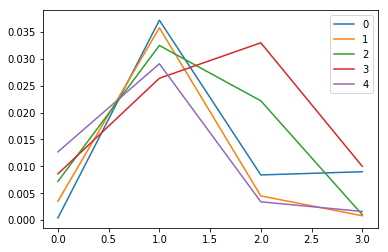

In [61]:
for i, u in enumerate(util_delta):
    plt.plot(u, label=f'{i}')
plt.legend()

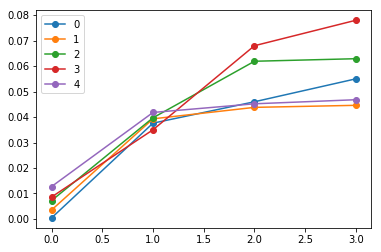

In [63]:
for i, u in enumerate(util):
    plt.plot(u, label=f'{i}', marker='o')
plt.legend()

In [64]:
solver(util_delta, pre_decision, budget)

Solver:
Time elapsed: 113.1 ms
Max utility: 0.1098
Decision variables (selected layers):
Object 0: []
Object 1: []
Object 2: []
Object 3: [0, 1, 2]
Object 4: [0, 1]

Updated decision after optimization
Object 0 [0, 0, 0, 0]
Object 1 [0, 0, 0, 0]
Object 2 [0, 0, 0, 0]
Object 3 [1, 1, 1, 0]
Object 4 [1, 1, 0, 0]


In [40]:
'''
list all combinations of selecting "budget" items, return the combination with the maximum utility
time complexity increases with greater "budget"
'''
maximize_utility_brute_force(util_delta, copy.deepcopy(pre_decision), budget)

Brute force:
Time elapsed: 11.68 ms
Max utility: 0.4891
Decision variables (selected layers):
Object 0: []
Object 1: []
Object 2: []
Object 3: [0, 1, 2, 3]
Object 4: [0]


(0.4891,
 [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [1, 1, 1, 1], [1, 0, 0, 0]])

In [41]:
'''
select 1 item with maximum utiliy at a time from the next feasible layer of each objects. 

For example, if the previous selection:
    Layer 0  1  2  3     feasible layer
Object 0 [1, 0, 0, 0] -> layer 1
Object 1 [0, 0, 0, 0] -> layer 0
Object 2 [1, 1, 0, 0] -> layer 2        -> select one with max. utility
Object 3 [1, 1, 1, 0] -> layer 3
Object 4 [0, 0, 0, 0] -> layer 0

Ignore the impact of multiple layers selected at a time may yield greater utility
'''
maximize_utility_one_at_a_time(util_delta, copy.deepcopy(pre_decision), budget)

Iterative select one at a time
Time elapsed: 0.17 ms
Max utility: 0.3799
Decision variables (selected layers):
Object 0: []
Object 1: []
Object 2: []
Object 3: [0]
Object 4: [0, 1, 2, 3]


(0.3799,
 [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [1, 0, 0, 0], [1, 1, 1, 1]])

In [42]:
'''
assume the tendency of selecting all layers from one object,
and compare with the "select 1 algo." (the previous algo.)

1. Check if we can get all layers of an object, record the utility
2. Run the "select 1 algo."
3. Compare utility of 1. and 2. to get final result
'''
maximize_utility_prefer_all(util_delta, copy.deepcopy(pre_decision), budget)

Iterative but prefer all layers of an object:
Time elapsed: 0.62 ms
Max utility: 0.4891
Decision variables (selected layers):
Object 0: []
Object 1: []
Object 2: []
Object 3: [0, 1, 2, 3]
Object 4: [0]


(0.4891,
 [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [1, 1, 1, 1], [1, 0, 0, 0]])

In [ ]:
#### wrong
def maximize_utility_dp(util, pre_decision, B):
    num_objects = len(util)
    num_layers = len(util[0])
    
    start = time.time()
    # Memoization table to store results of subproblems
    # max utility of selecting 1, 2, 3,...B items
    memo = {}
    
    def dp(budget):
        print(f"dp({budget})")
        # Check if the subproblem has already been solved
        if budget in memo:
            return memo[budget]            
        
        # Base case: select none
        if budget == 0:
            memo[budget] = (0, [None])
            return 0, [None]
            
        # Base case: only select one
        if budget == 1:
            next_layer = list(map(lambda row: next((index for index, value in enumerate(row) if value == 0), -1), pre_decision))
            # Terminate when nothing to select
            if next_layer == [-1] * num_objects:
                memo[budget] = (0, [None])
                return 0, [None]
            
            max_utility = float('-inf')
            selected_obj = None
            for obj_idx, layer_idx in enumerate(next_layer):
                if layer_idx != -1 and util[obj_idx][layer_idx] > max_utility:
                    max_utility = util[obj_idx][layer_idx]
                    selected_obj = obj_idx
            pre_decision[selected_obj][next_layer[selected_obj]] = 1
            memo[budget] = (max_utility, (selected_obj, next_layer[selected_obj]))
            print(f"memo[{budget}]",memo[budget])
            return max_utility, (selected_obj, next_layer[selected_obj])
        

        else:
            print(f"dp({budget}-1)",dp(budget-1))
            max_util, selection = dp(budget - 1)
            
            memo[budget] = (max_util, selection)

        
        
    # Call the dynamic programming function
    max_utility, selected_layers = dp(B)
    
    
    print("Time elapsed:", (time.time() - start)*1000, "ms")
    # Update the previous decision based on the selected layers
    for obj_idx, layers in enumerate(selected_layers):
        for layer_idx in layers:
            pre_decision[obj_idx][layer_idx] = 1
    
    return max_utility, pre_decision

In [ ]:
max_utility, updated_pre_decision = maximize_utility_dp(util_delta, copy.deepcopy(pre_decision), B)

# Print the results
print("Max utility:", round(max_utility,4))
print("Updated decision after optimization:")
for i, decision in enumerate(updated_pre_decision):
    print("Object", i, decision)